# PROJECT 3 COMPUTER VISION

- Joanna Szczublińska 156070
- Wiktoria Szarzyńska 156058

### `Step 1: Choose the dataset and convert images into grayscale.`

In [42]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import pandas as pd
from tabulate import tabulate
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
import random
from sklearn.model_selection import KFold

In [2]:
data_dir = "flowers"

In [3]:
classes = os.listdir(data_dir)
print(classes)

['daisy']


In [4]:
X_gray = []
Y_color = []
labels = []

for label, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            img = cv2.imread(img_path)


            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img = cv2.resize(img, (200, 200))
                
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                X_gray.append(gray)
                Y_color.append(img)
                labels.append(label)

In [5]:
X_gray = np.array(X_gray, dtype=np.float32).reshape(-1, 200, 200, 1) / 255.0
Y_color = np.array(Y_color, dtype=np.float32) / 255.0
labels = np.array(labels)

In [6]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_gray, Y_color, test_size=0.3, random_state=42) #70% for training and 30% for temporary dataset
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42) #50% for validation and 50% for testing

In [7]:
print(f"#Training set: {len(X_train)}")
print(f"#Validation set: {len(X_val)}")
print(f"#Test set: {len(X_test)}")

#Training set: 534
#Validation set: 115
#Test set: 115


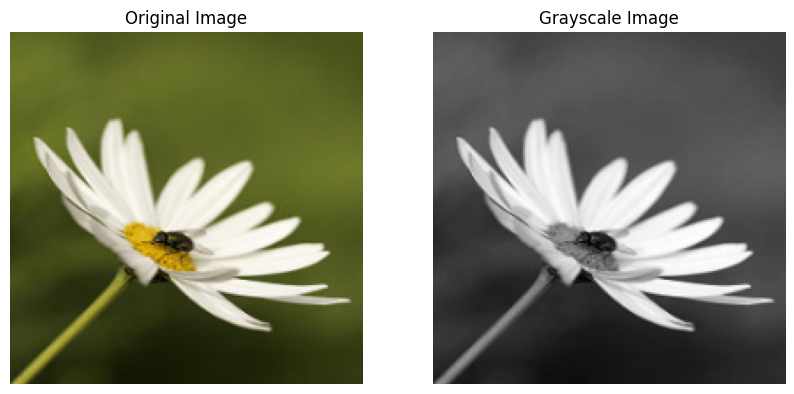

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(Y_train[0])  
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(X_train[0].squeeze(), cmap="gray")  
plt.axis("off")

plt.show()

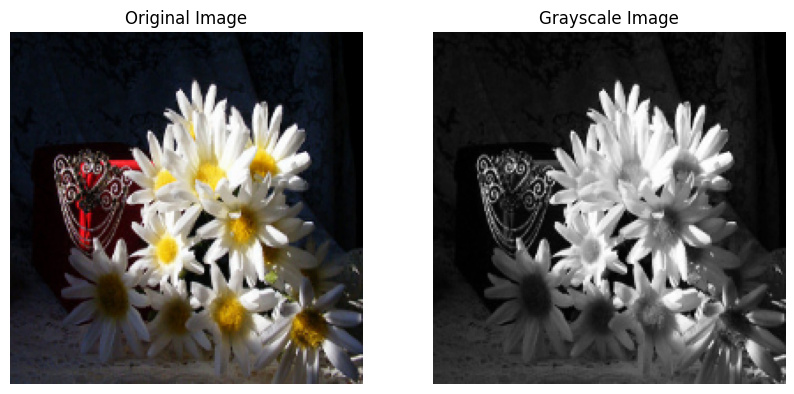

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(Y_train[1])  
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(X_train[1].squeeze(), cmap="gray")  
plt.axis("off")

plt.show()

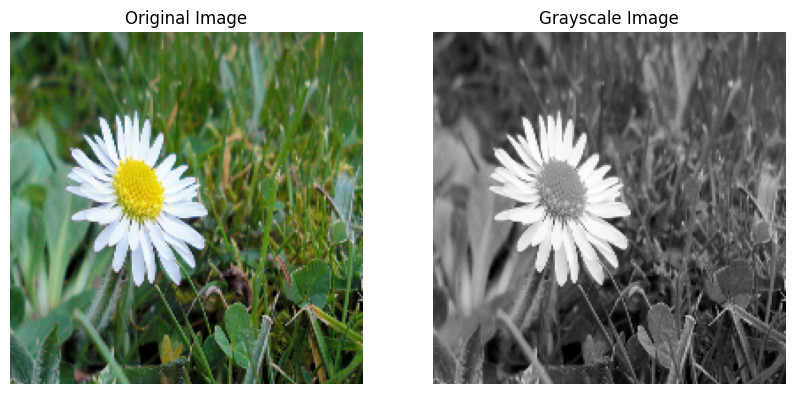

In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(Y_train[10])  
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(X_train[10].squeeze(), cmap="gray")  
plt.axis("off")

plt.show()

### `Step 2: Model, ready architecture trained from scratch.`

In [11]:
input_shape = (200, 200, 1)

# ENCODER
def build_encoder(input_layer):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    return x

# DECODER
def build_decoder(encoded_layer):
    x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(encoded_layer)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return output_layer

In [12]:
input_layer = Input(shape=input_shape)
encoded = build_encoder(input_layer)
decoded = build_decoder(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 200, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 200, 200, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,307 (5.07 MB)

 Trainable params: 1,330,307 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

### `Step 3: Initial model training.`

In [13]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience=5, restore_best_weights=True)

In [14]:
def psnr_metric(y_true, y_pred): # y_true and y_pred are numpy arrays
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [15]:
def ssim_metric(y_true, y_pred): # y_true: ground truth, y_pred: prediction
    y_true = tf.image.rgb_to_grayscale(y_true)
    y_pred = tf.image.rgb_to_grayscale(y_pred)
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [16]:
autoencoder.compile(
    optimizer='adam',
    loss='mse',  
    metrics=[psnr_metric, ssim_metric]  
)

In [17]:
batch_size = 32
epochs = 5

history = autoencoder.fit(
    X_train, Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = [early_stopping]
)

val_results = autoencoder.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_results[0]:.4f}, PSNR: {val_results[1]:.4f}, SSIM: {val_results[2]:.4f}")

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - loss: 0.0911 - psnr_metric: 10.8148 - ssim_metric: 0.3238 - val_loss: 0.0455 - val_psnr_metric: 13.7586 - val_ssim_metric: 0.4245
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 0.0459 - psnr_metric: 13.9150 - ssim_metric: 0.4115 - val_loss: 0.0281 - val_psnr_metric: 15.9602 - val_ssim_metric: 0.4640
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - loss: 0.0249 - psnr_metric: 16.5096 - ssim_metric: 0.4727 - val_loss: 0.0248 - val_psnr_metric: 16.5649 - val_ssim_metric: 0.4985
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0232 - psnr_metric: 16.8770 - ssim_metric: 0.4908 - val_loss: 0.0224 - val_psnr_metric: 17.0804 - val_ssim_metric: 0.5155
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.0200 - psnr_metric: 17.5435 - ssim_metric: 0.5188 - val_loss: 0.0204 - val_psnr_metric: 17.5777 - val_ssim_metric: 0.5417
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step - loss: 0.0208 - psnr_metric: 17.4244 - ssim_metric: 0.5

In [18]:
test_results = autoencoder.evaluate(X_test, Y_test)
print(f"Test Loss: {test_results[0]:.4f}, PSNR: {test_results[1]:.4f}, SSIM: {test_results[2]:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 581ms/step - loss: 0.0196 - psnr_metric: 17.8440 - ssim_metric: 0.5499
Test Loss: 0.0197, PSNR: 17.8137, SSIM: 0.5500


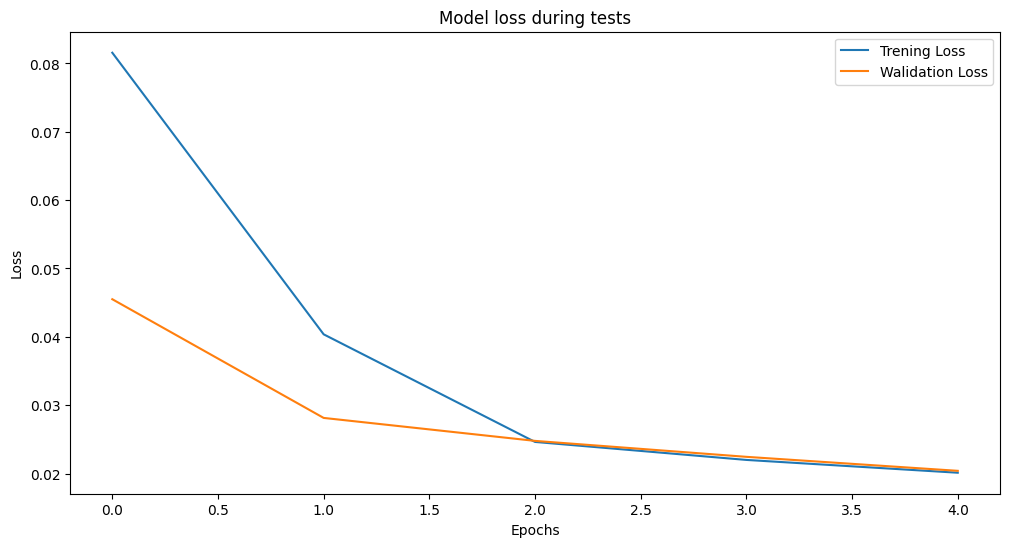

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Trening Loss')
plt.plot(history.history['val_loss'], label='Walidation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss during tests')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


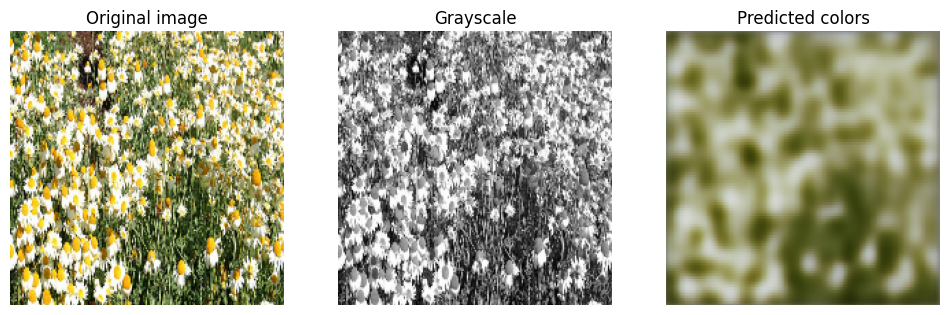

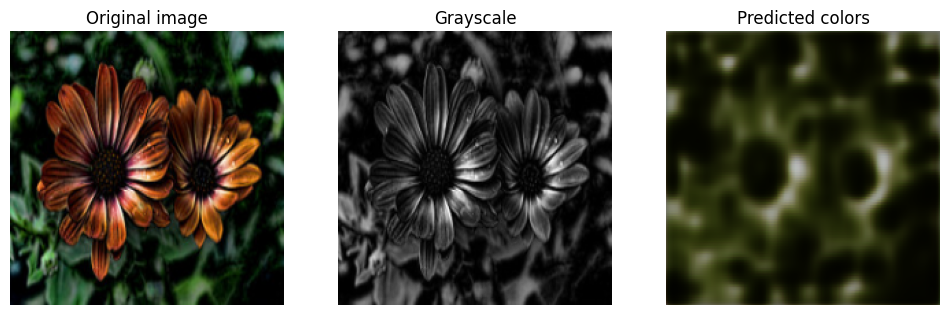

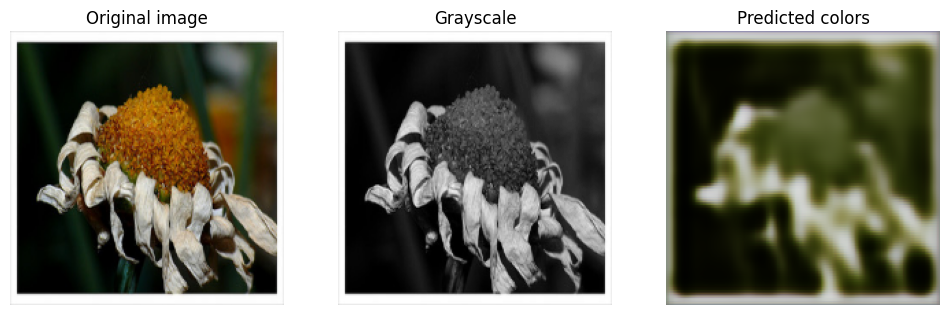

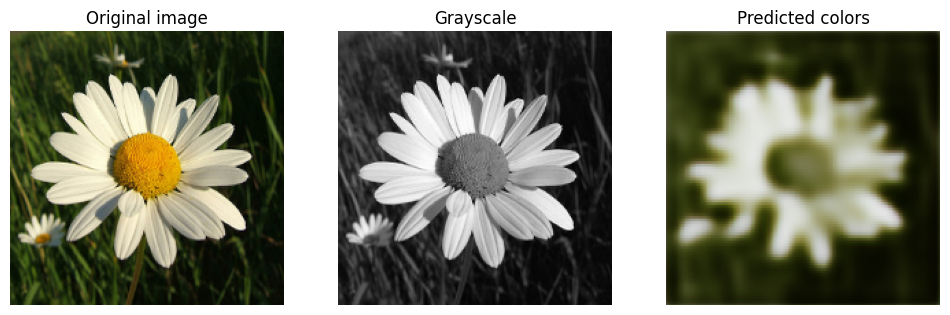

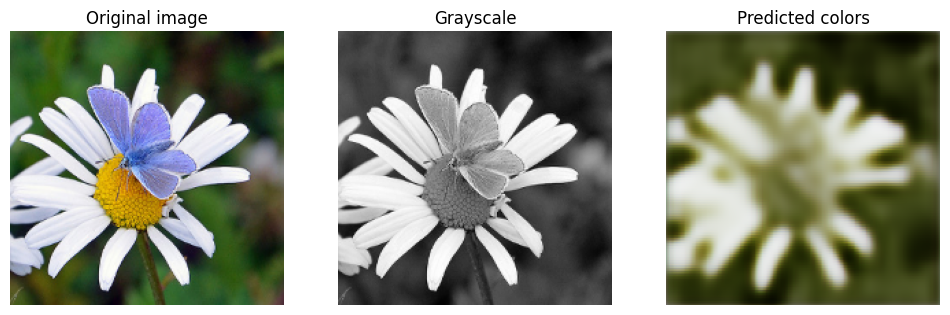

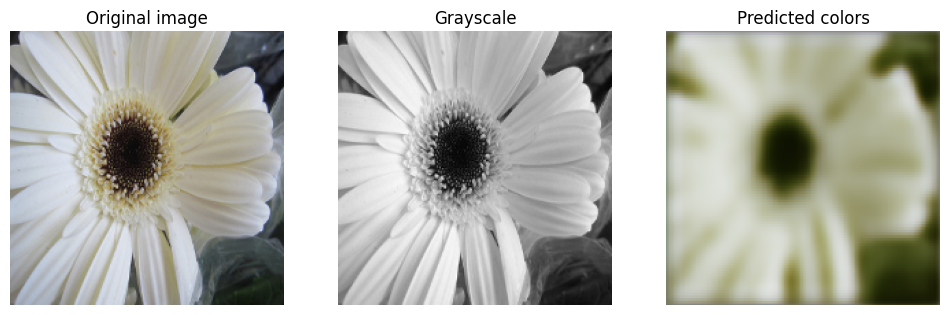

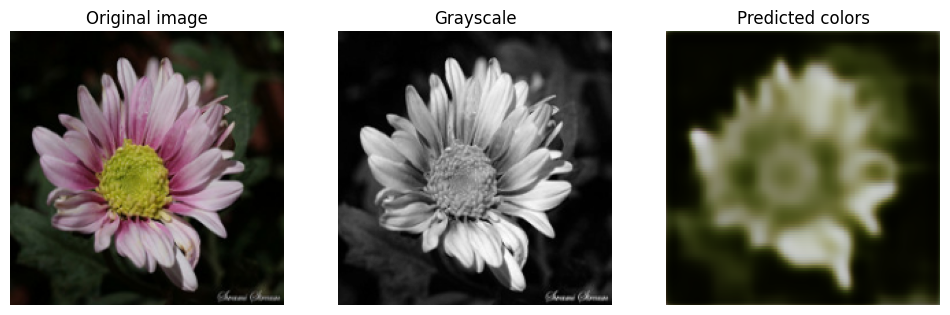

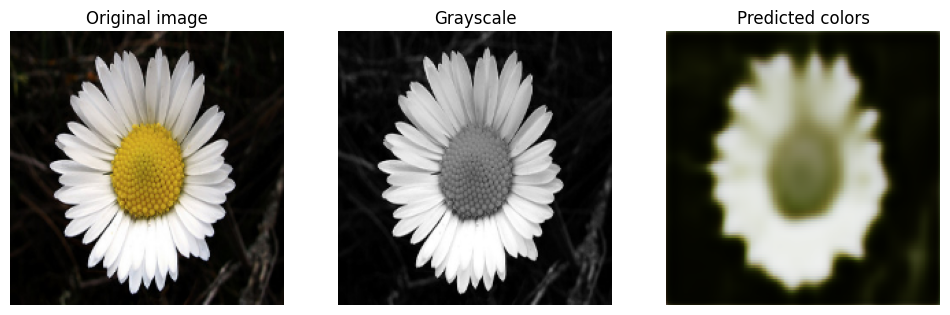

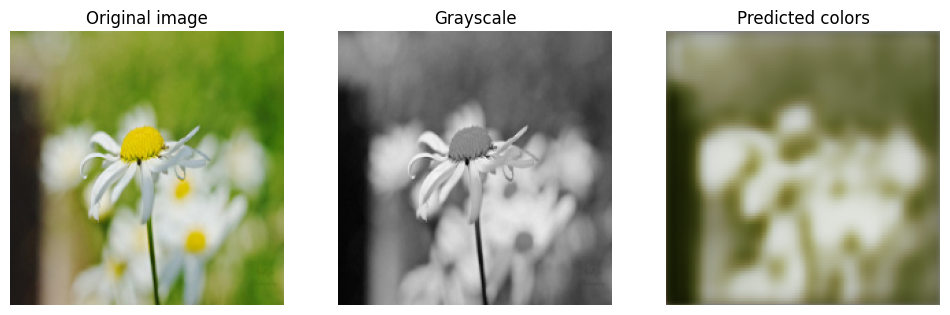

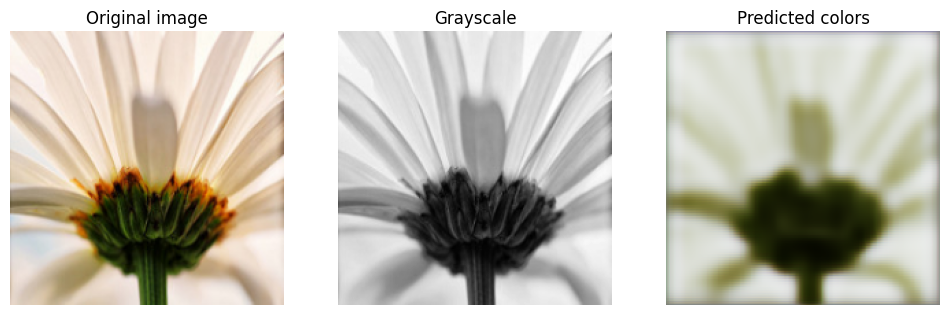

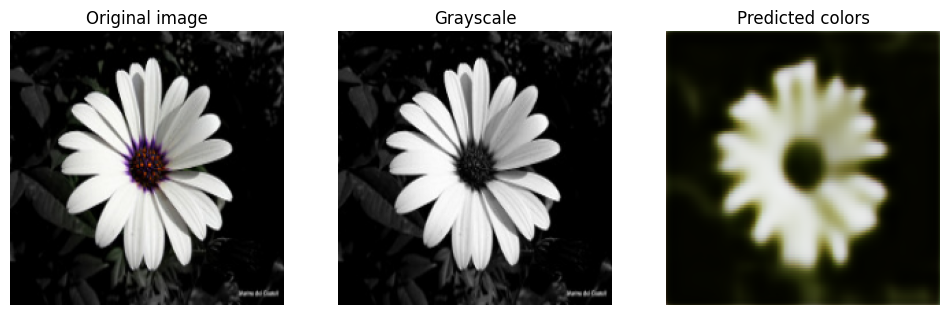

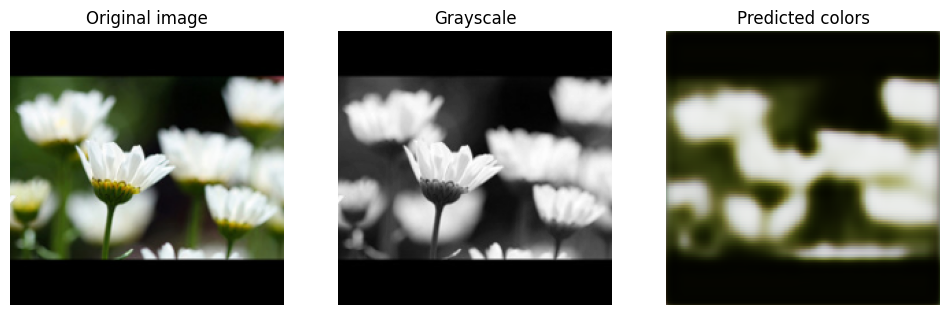

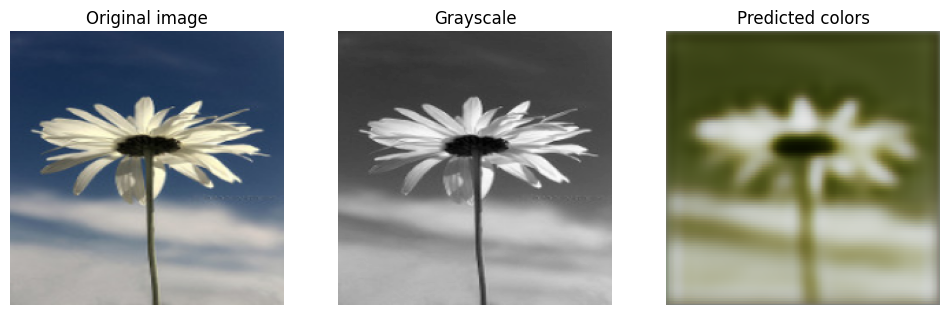

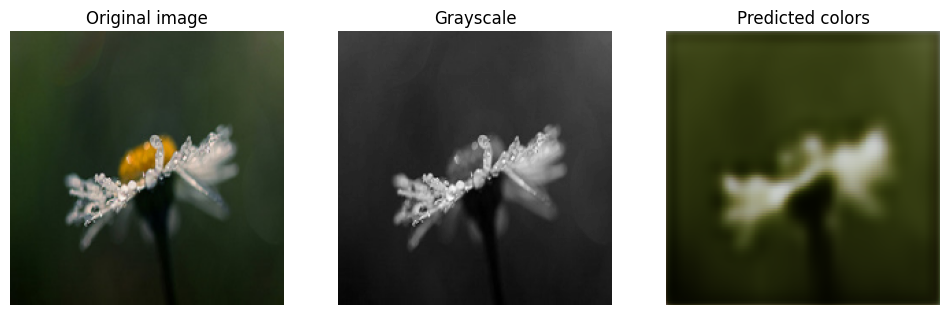

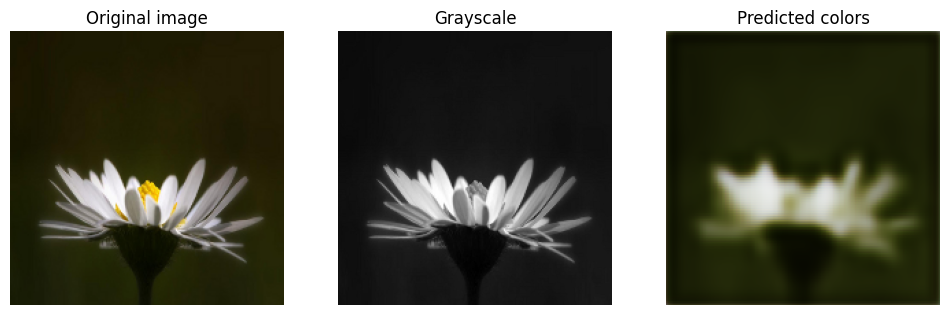

In [20]:
n = 15
predicted_images = autoencoder.predict(X_test[:n])

for i in range(n):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original image")
    plt.imshow(Y_test[i])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grayscale")
    plt.imshow(X_test[i].reshape(200, 200), cmap='gray')
    plt.axis('off')
    

    plt.subplot(1, 3, 3)
    plt.title("Predicted colors")
    plt.imshow(predicted_images[i])
    plt.axis('off')

    plt.show()

### `Step 4: Let's make our model perfect.`

#### `Step 4.1: Testing three (3) different optimizers.`

In [25]:
optimizers = {
    'Adam': Adam(learning_rate=0.001),
    'RMSprop': RMSprop(learning_rate=0.001),
    'SGD': SGD(learning_rate=0.01, momentum=0.9)  # With momentum for better convergence
}

results = {}

In [26]:
for name, optimizer in optimizers.items():
    print(f"\nTraining with {name} optimizer:")

    autoencoder = Model(inputs = input_layer, outputs = decoded)
    autoencoder.compile(
        optimizer = optimizer,
        loss = 'mse',
        metrics = [psnr_metric, ssim_metric]  
    )

    history = autoencoder.fit(
        X_train, Y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose = 1
    )

    val_loss, psnr, ssim = autoencoder.evaluate(X_val, Y_val, verbose=0)
    results[name] = {
        'Validation Loss': val_loss,
        'PSNR': psnr,
        'SSIM': ssim
    }    


Training with Adam optimizer:
Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - loss: 0.0443 - psnr_metric: 14.7152 - ssim_metric: 0.4563 - val_loss: 0.0248 - val_psnr_metric: 16.5833 - val_ssim_metric: 0.5013
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.0231 - psnr_metric: 16.8671 - ssim_metric: 0.5011 - val_loss: 0.0202 - val_psnr_metric: 17.5547 - val_ssim_metric: 0.5333
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.0188 - psnr_metric: 17.9287 - ssim_metric: 0.5437 - val_loss: 0.0187 - val_psnr_metric: 17.9847 - val_ssim_metric: 0.5496
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.0170 - psnr_metric: 18.3442 - ssim_metric: 0.5628 - val_loss: 0.0175 - val_psnr_metric: 18.3288 - val_ssim_metric: 0.5771
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0163 - psnr_metric: 18.5490 - ssim_metric: 0.5799 - val_loss: 0.0170 - val_psnr_metric: 18.5015 - val_ssim_metric: 0.5912

Training with RMSprop optimizer:
Epoch 1/5
17/17 ━━━━━━━━━━━━━━

In [27]:
print("\nComparison of Optimizers:")
for name, metrics in results.items():
    print(f"{name} - Validation Loss: {metrics['Validation Loss']:.4f}, PSNR: {metrics['PSNR']:.2f}, SSIM: {metrics['SSIM']:.4f}")


Comparison of Optimizers:
Adam - Validation Loss: 0.0170, PSNR: 18.50, SSIM: 0.5912
RMSprop - Validation Loss: 0.0213, PSNR: 17.31, SSIM: 0.5614
SGD - Validation Loss: 0.0180, PSNR: 18.19, SSIM: 0.5778


In [31]:
table_data = [
    [optimizer, metrics["Validation Loss"], metrics["PSNR"], metrics["SSIM"]]
    for optimizer, metrics in results.items()
]

table = tabulate(
    table_data,
    headers=["Optimizer", "Validation Loss", "PSNR", "SSIM"],
    tablefmt="grid"
)

print("\nComparison of Optimizers:")
print(table)


Comparison of Optimizers:
+-------------+-------------------+---------+----------+
| Optimizer   |   Validation Loss |    PSNR |     SSIM |
+=============+===================+=========+==========+
| Adam        |         0.0170169 | 18.5015 | 0.591187 |
+-------------+-------------------+---------+----------+
| RMSprop     |         0.0213206 | 17.3111 | 0.561364 |
+-------------+-------------------+---------+----------+
| SGD         |         0.0179742 | 18.1918 | 0.577785 |
+-------------+-------------------+---------+----------+


#### `Step 4.2: Testing three (3) different loss functions.`

In [33]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [34]:
def train_model_with_loss(loss_function, loss_name):
    print(f"\nTraining model with {loss_name} loss...")
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss=loss_function, metrics=[psnr_metric, ssim_metric])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = autoencoder.fit(
        X_train, Y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=0
    )
    
    val_results = autoencoder.evaluate(X_val, Y_val, verbose=0)
    return {"Validation Loss": val_results[0], "PSNR": val_results[1], "SSIM": val_results[2]}


In [35]:
loss_results = {}

loss_functions = {
    "Mean Squared Error (MSE)": MeanSquaredError(),
    "Mean Absolute Error (MAE)": MeanAbsoluteError(),
    "Structural Similarity Index (SSIM) Loss": ssim_loss
}

for loss_name, loss_fn in loss_functions.items():
    loss_results[loss_name] = train_model_with_loss(loss_fn, loss_name)



Training model with Mean Squared Error (MSE) loss...

Training model with Mean Absolute Error (MAE) loss...

Training model with Structural Similarity Index (SSIM) Loss loss...

### Loss Function Comparison:

| Loss Function                           |   Validation Loss |    PSNR |     SSIM |
|:----------------------------------------|------------------:|--------:|---------:|
| Mean Squared Error (MSE)                |         0.0162716 | 18.74   | 0.602815 |
| Mean Absolute Error (MAE)               |         0.083721  | 19.0205 | 0.647739 |
| Structural Similarity Index (SSIM) Loss |         0.344917  | 19.2228 | 0.729718 |


In [37]:
table_data = [
    [optimizer, metrics["Validation Loss"], metrics["PSNR"], metrics["SSIM"]]
    for optimizer, metrics in loss_results.items()
]

# Create the table with tabulate
table = tabulate(
    table_data,
    headers=["Optimizer", "Validation Loss", "PSNR", "SSIM"],
    tablefmt="grid"
)

# Print the result
print("\nComparison of Optimizers:")
print(table)


Comparison of Optimizers:
+-----------------------------------------+-------------------+---------+----------+
| Optimizer                               |   Validation Loss |    PSNR |     SSIM |
+=========================================+===================+=========+==========+
| Mean Squared Error (MSE)                |         0.0162716 | 18.74   | 0.602815 |
+-----------------------------------------+-------------------+---------+----------+
| Mean Absolute Error (MAE)               |         0.083721  | 19.0205 | 0.647739 |
+-----------------------------------------+-------------------+---------+----------+
| Structural Similarity Index (SSIM) Loss |         0.344917  | 19.2228 | 0.729718 |
+-----------------------------------------+-------------------+---------+----------+


#### `Step 4.3: Hyperparameter tuning or estimation.`

Training with lr=1.4174088852014156e-05, batch_size=25, epochs=5...
Training with lr=0.00030636080503457794, batch_size=16, epochs=5...
Training with lr=0.0014069149639841655, batch_size=28, epochs=10...
Training with lr=0.00030636080503457794, batch_size=16, epochs=10...


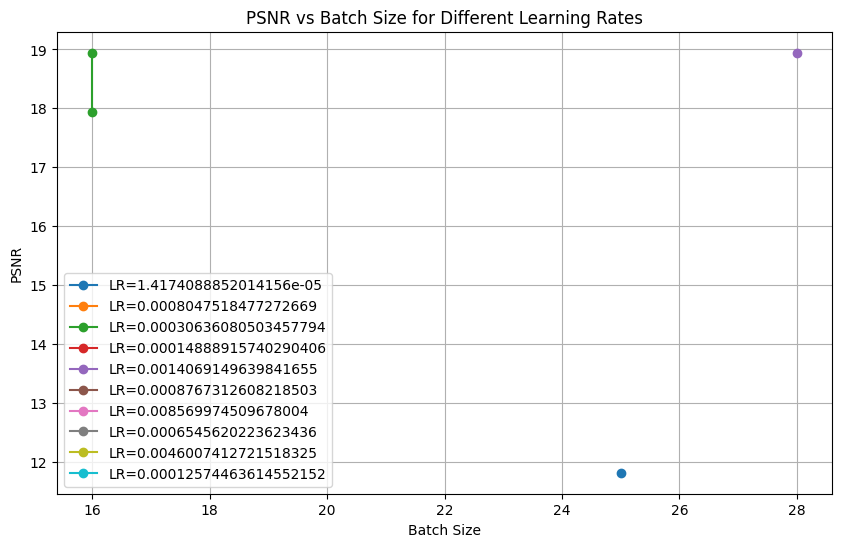

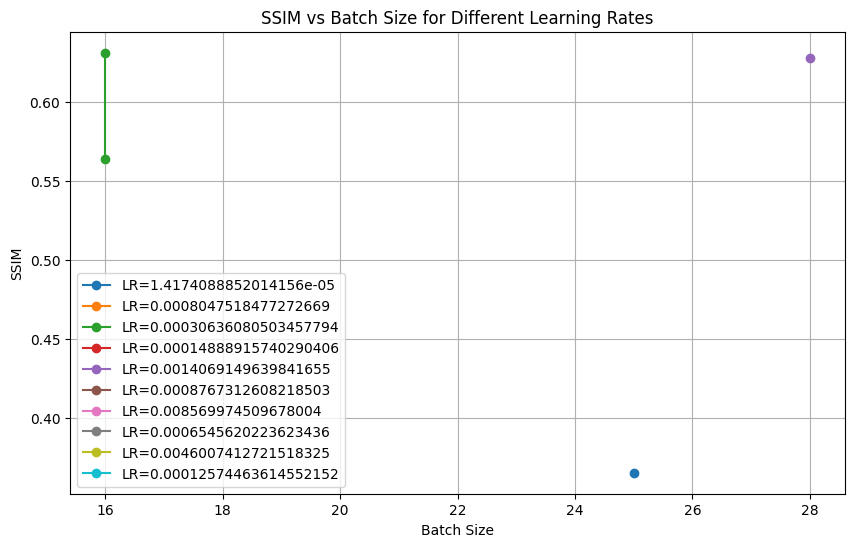

In [41]:
learning_rates = [10**random.uniform(-5, -2) for _ in range(10)]
batch_sizes = [random.randint(16, 64) for _ in range(10)]
epochs_range = (5, 15)

def train_model_with_params(learning_rate, batch_size, epochs):
    
    input_layer = Input(shape=input_shape)
    encoded = build_encoder(input_layer)
    decoded = build_decoder(encoded)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[psnr_metric, ssim_metric])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    
    history = autoencoder.fit(
        X_train, Y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=0
    )
    
    
    val_loss, psnr, ssim = autoencoder.evaluate(X_val, Y_val, verbose=0)
    
    return psnr, ssim

results = []


for _ in range(4):  
    lr = random.choice(learning_rates)
    bs = random.choice(batch_sizes)
    ep = random.choice(epochs)
    
    print(f"Training with lr={lr}, batch_size={bs}, epochs={ep}...")
    psnr, ssim = train_model_with_params(lr, bs, ep)
    results.append((lr, bs, ep, psnr, ssim))


df = pd.DataFrame(results, columns=['Learning Rate', 'Batch Size', 'Epochs', 'PSNR', 'SSIM'])


plt.figure(figsize=(10, 6))
for lr in learning_rates:
    subset = df[df['Learning Rate'] == lr]
    plt.plot(subset['Batch Size'], subset['PSNR'], label=f'LR={lr}', marker='o')

plt.title('PSNR vs Batch Size for Different Learning Rates')
plt.xlabel('Batch Size')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
for lr in learning_rates:
    subset = df[df['Learning Rate'] == lr]
    plt.plot(subset['Batch Size'], subset['SSIM'], label=f'LR={lr}', marker='o')

plt.title('SSIM vs Batch Size for Different Learning Rates')
plt.xlabel('Batch Size')
plt.ylabel('SSIM')
plt.legend()
plt.grid(True)
plt.show()


#### `Step 4.4: Cross-validation.`

In [43]:
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cv_results = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]

    input_layer = Input(shape=input_shape)
    encoded = build_encoder(input_layer)
    decoded = build_decoder(encoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mse', metrics=[psnr_metric, ssim_metric])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = autoencoder.fit(
        X_train_fold, Y_train_fold,
        batch_size=32,
        epochs=5,
        validation_data=(X_val_fold, Y_val_fold),
        callbacks=[early_stopping],
        verbose=0
    )

    val_loss, psnr, ssim = autoencoder.evaluate(X_val_fold, Y_val_fold, verbose=0)
    cv_results.append((val_loss, psnr, ssim))

cv_results = np.array(cv_results)
avg_val_loss = np.mean(cv_results[:, 0])
avg_psnr = np.mean(cv_results[:, 1])
avg_ssim = np.mean(cv_results[:, 2])

print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")


Average Validation Loss: 0.0195
Average PSNR: 17.7466
Average SSIM: 0.5350


### `Step 5: Final training.`